
# Training and Performance Analysis of ResNet Architecture
* ECE-GY 9143 High Performance Machine Learning
* Author: Anuj Attri
---

## Importing Libraries to be used
The implementation is achieved using Pytorch exploiting features of Pytorch profiler.

In [58]:
from __future__ import print_function

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [59]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

## Dataset and DataLoader
Dataset used is Cifar-10.

In [60]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


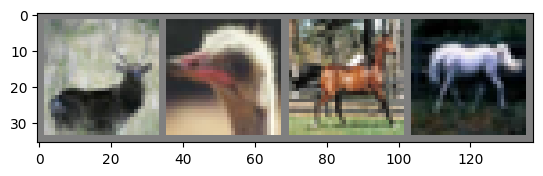

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


## Defining the Model

### BasicBlock


In [63]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [64]:
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


In [65]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [66]:
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


### ResNet

In [67]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [68]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [69]:
net = ResNet34().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

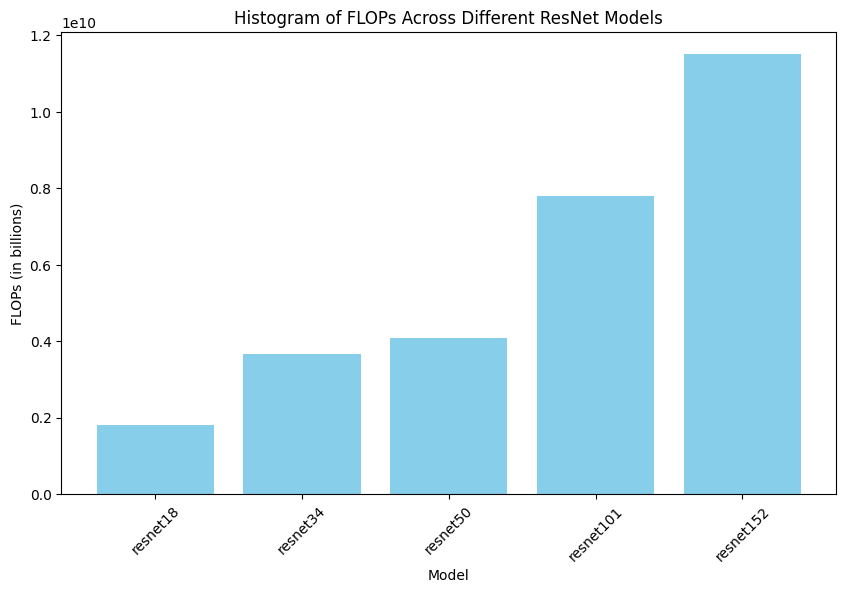

In [70]:
import matplotlib.pyplot as plt
from torchinfo import summary
import torch
import torchvision.models as models

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# List of model names
model_names = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]

# Dictionary to hold models
models_dict = {
    "resnet18": models.resnet18().to(device),
    "resnet34": models.resnet34().to(device),
    "resnet50": models.resnet50().to(device),
    "resnet101": models.resnet101().to(device),
    "resnet152": models.resnet152().to(device)
}

# List to store FLOPs data
flops_data = []
labels = []

# Iterate over models and calculate FLOPs
for model_name, model in models_dict.items():
    model_info = summary(model, input_size=(1, 3, 224, 224), verbose=0)
    flops = model_info.total_mult_adds
    flops_data.append(flops)
    labels.append(model_name)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(labels, flops_data, color='skyblue')
plt.xlabel('Model')
plt.ylabel('FLOPs (in billions)')
plt.title('Histogram of FLOPs Across Different ResNet Models')
plt.xticks(rotation=45)
plt.show()


In [71]:
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity, tensorboard_trace_handler
# Function to run a forward pass and profile
def profile_model(model, input_tensor):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 record_shapes=True, profile_memory=True) as prof:
        with record_function("model_inference"):
            model(input_tensor)
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
    return prof

# Dummy input for profiling
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Iterate over models and profile each
for model_name, model in models_dict.items():
    print(f"Profiling {model_name}")
    profiler = profile_model(model, input_tensor)

Profiling resnet18
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        19.89%       3.575ms        99.84%      17.941ms      17.941ms       0.000us         0.00%       4.070ms       4.070ms           0 b           0 b        

In [72]:
# Function to generate and save trace
def generate_trace(model, input_tensor, trace_dir, model_name):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
                 on_trace_ready=tensorboard_trace_handler(trace_dir + f"/{model_name}"),
                 record_shapes=True, profile_memory=True) as prof:
        for _ in range(5):
            model(input_tensor)
            prof.step()  # Next step in profiling

# Dummy input for profiling
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Trace directory
trace_dir = "model_traces"

# Iterate over models and generate trace for each
for model_name, model in models_dict.items():
    print(f"Generating trace for {model_name}")
    generate_trace(model, input_tensor, trace_dir, model_name)
    print(f"Trace for {model_name} saved in {trace_dir}/{model_name}")

Generating trace for resnet18
Trace for resnet18 saved in model_traces/resnet18
Generating trace for resnet34
Trace for resnet34 saved in model_traces/resnet34
Generating trace for resnet50
Trace for resnet50 saved in model_traces/resnet50
Generating trace for resnet101
Trace for resnet101 saved in model_traces/resnet101
Generating trace for resnet152
Trace for resnet152 saved in model_traces/resnet152


In [73]:
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [74]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [75]:
# Training
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [82]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the SummaryWriter
writer = SummaryWriter(log_dir=log_dir)

# Modified training function with TensorBoard logging
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        batch_start_time = time.time()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        batch_time = time.time() - batch_start_time

        if batch_idx % 100 == 99:
            avg_loss = train_loss / 100
            acc = 100. * correct / total
            print('[%d, %5d] Loss: %.6f | Acc: %.3f%% (%d/%d) | Batch Time: %.3f seconds' %
                  (epoch + 1, batch_idx + 1, avg_loss, acc, correct, total, batch_time))
            writer.add_scalar('Training Loss', avg_loss, epoch * len(train_loader) + batch_idx)
            writer.add_scalar('Accuracy', acc, epoch * len(train_loader) + batch_idx)
            train_loss = 0  # Reset the loss for the next 100 batches

    epoch_time = time.time() - start_time
    print('Epoch finished in %.3f seconds' % epoch_time)
    writer.add_scalar('Epoch Time', epoch_time, epoch)

    return train_loss, acc, epoch_time


In [77]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
import os

# Define the directory to store the TensorBoard logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Start TensorBoard
%tensorboard --log_dir $log_dir
num_epochs = 5  # Define the number of epochs to train
for epoch in range(num_epochs):
    train_loss, acc, epoch_time = train(epoch)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-05-12 01:11:28.618407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 01:11:28.618490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 01:11:28.619650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 01:11:29.597581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for de


Epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,   100] Loss: 1.361740 | Acc: 50.242% (6431/12800) | Batch Time: 0.164 seconds
[1,   200] Loss: 1.271116 | Acc: 52.273% (13382/25600) | Batch Time: 0.168 seconds
[1,   300] Loss: 1.193661 | Acc: 53.695% (20619/38400) | Batch Time: 0.166 seconds
Epoch finished in 67.802 seconds

Epoch: 1
[2,   100] Loss: 1.042399 | Acc: 62.180% (7959/12800) | Batch Time: 0.167 seconds
[2,   200] Loss: 1.005797 | Acc: 63.254% (16193/25600) | Batch Time: 0.173 seconds
[2,   300] Loss: 0.949454 | Acc: 64.326% (24701/38400) | Batch Time: 0.167 seconds
Epoch finished in 67.932 seconds

Epoch: 2
[3,   100] Loss: 0.853769 | Acc: 69.703% (8922/12800) | Batch Time: 0.166 seconds


In [ ]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))